In [2]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [4]:
import os
import shutil
import random

random.seed(42)

DATASET_DIR = 'dataset'
IMAGES_DIR = os.path.join(DATASET_DIR, 'images')
LABELS_DIR = os.path.join(DATASET_DIR, 'labels')
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
TEST_DIR = os.path.join(DATASET_DIR, 'test')

# Get all image files (assuming .png, change if needed)
image_files = [f for f in os.listdir(IMAGES_DIR) if os.path.isfile(os.path.join(IMAGES_DIR, f))]
image_ids = [os.path.splitext(f)[0] for f in image_files]

# Shuffle and split
random.shuffle(image_ids)
split_idx = int(len(image_ids) * 0.95)
train_ids = image_ids[:split_idx]
test_ids = image_ids[split_idx:]

def copy_to_structure(ids, target_dir):
    for sample_id in ids:
        img_file = sample_id + '.JPG'
        label_file = sample_id + '.png'  # assumes same name for label

        sample_dir = os.path.join(target_dir, sample_id)
        images_out = os.path.join(sample_dir, 'images')
        masks_out = os.path.join(sample_dir, 'masks')

        os.makedirs(images_out, exist_ok=True)
        os.makedirs(masks_out, exist_ok=True)

        # Copy image
        src_img = os.path.join(IMAGES_DIR, img_file)
        if os.path.exists(src_img):
            shutil.copy(src_img, os.path.join(images_out, img_file))
        else:
            print(f"Warning: Image not found for {sample_id}")

        # Copy label
        src_label = os.path.join(LABELS_DIR, label_file)
        if os.path.exists(src_label):
            shutil.copy(src_label, os.path.join(masks_out, label_file))
        else:
            print(f"Warning: Label not found for {sample_id}")

# Clear old train/test folders if they exist
for folder in [TRAIN_DIR, TEST_DIR]:
    if os.path.exists(folder):
        shutil.rmtree(folder)

copy_to_structure(train_ids, TRAIN_DIR)
copy_to_structure(test_ids, TEST_DIR)

print(f"Done! Train: {len(train_ids)}, Test: {len(test_ids)}")

Done! Train: 1104, Test: 59


In [5]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'dataset/train/'
TEST_PATH = 'dataset/test/'

In [6]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)


In [7]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    img_path = os.path.join(path, 'images', id_ + '.jpg')
    if not os.path.exists(img_path):
        img_path = os.path.join(path, 'images', id_ + '.png')  # fallback to png if jpg not found
    img = imread(img_path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    mask_dir = os.path.join(path, 'masks')
    for mask_file in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_file)
        mask_ = imread(mask_path)
        if mask_.ndim == 3:
            mask_ = mask_[:, :, 0]
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Resizing training images and masks


100%|██████████| 1104/1104 [13:22<00:00,  1.38it/s]


Resizing test images


  0%|          | 0/59 [00:00<?, ?it/s]

100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


Done!


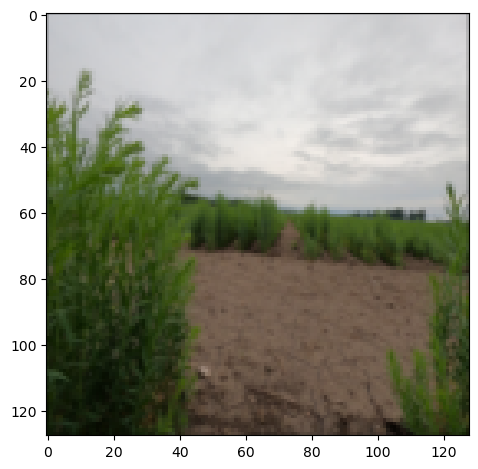

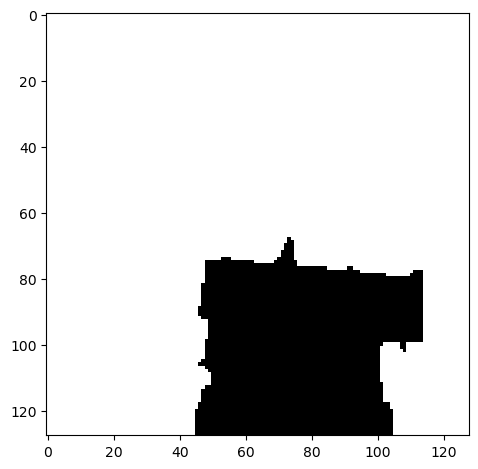

In [8]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(TEST_PATH, id_)
    img_path = os.path.join(path, 'images', id_ + '.jpg')
    if not os.path.exists(img_path):
        img_path = os.path.join(path, 'images', id_ + '.png')  # fallback to png if jpg not found
    img = imread(img_path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [12]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [13]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [14]:
#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 128, 128, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                              

In [16]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('tomatoBotSeg.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=8, epochs=25, callbacks=callbacks)


Epoch 1/25
111/111 [==============================] - 6s 46ms/step - loss: 0.0441 - accuracy: 0.9823 - val_loss: 0.0343 - val_accuracy: 0.9892
Epoch 2/25
111/111 [==============================] - 4s 34ms/step - loss: 0.0427 - accuracy: 0.9830 - val_loss: 0.0325 - val_accuracy: 0.9900
Epoch 3/25
111/111 [==============================] - 4s 34ms/step - loss: 0.0410 - accuracy: 0.9836 - val_loss: 0.0371 - val_accuracy: 0.9885
Epoch 4/25
111/111 [==============================] - 4s 33ms/step - loss: 0.0359 - accuracy: 0.9857 - val_loss: 0.0302 - val_accuracy: 0.9908
Epoch 5/25
111/111 [==============================] - 4s 33ms/step - loss: 0.0345 - accuracy: 0.9862 - val_loss: 0.0284 - val_accuracy: 0.9907
Epoch 6/25
111/111 [==============================] - 4s 33ms/step - loss: 0.0351 - accuracy: 0.9861 - val_loss: 0.0276 - val_accuracy: 0.9908
Epoch 7/25
111/111 [==============================] - 4s 33ms/step - loss: 0.0347 - accuracy: 0.9861 - val_loss: 0.0291 - val_accuracy: 0.9907

In [17]:

idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

2/2 [==============================] - 1s 938ms/step


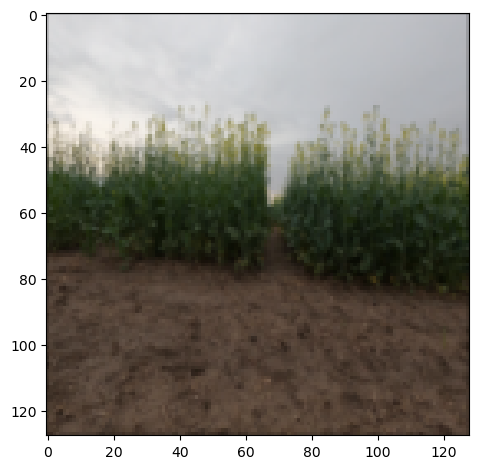

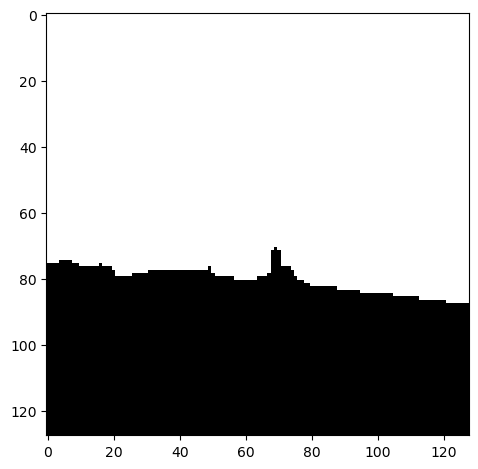

c:\Users\haito\.conda\envs\tf\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


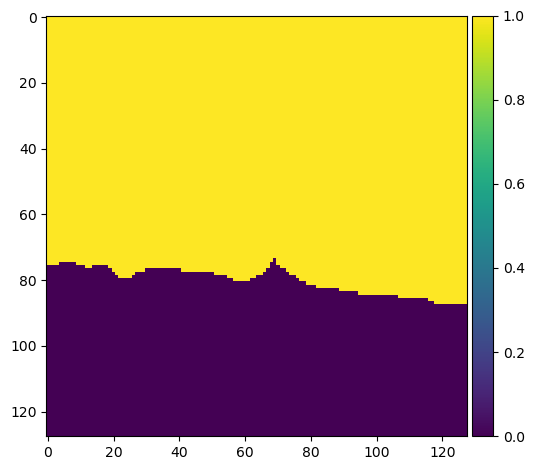

In [18]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()


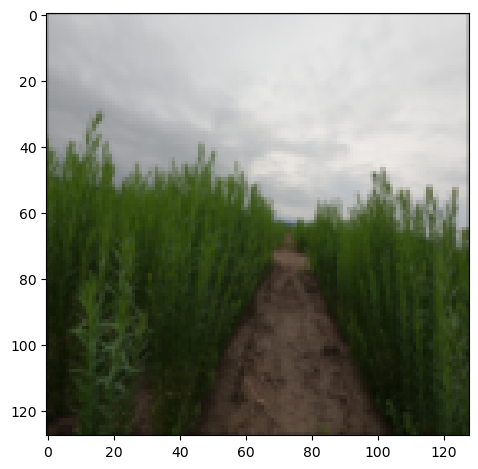

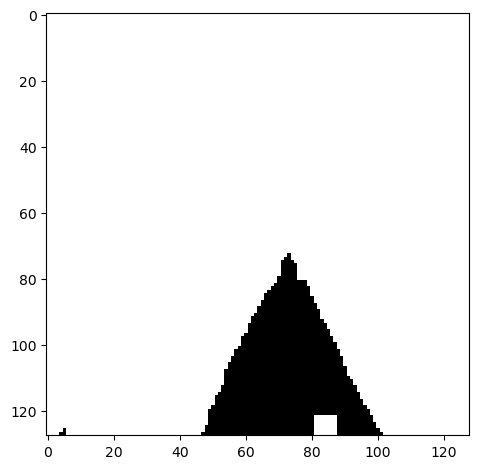

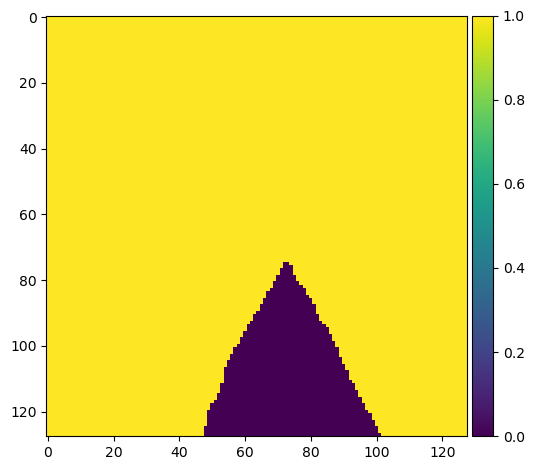

In [19]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def calculate_metrics(y_true, y_pred, n_classes):
    # Flatten the arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(n_classes))
    print("Confusion Matrix:\n", cm)

    # Pixel Accuracy
    pixel_accuracy = np.sum(y_true_flat == y_pred_flat) / len(y_true_flat)
    print(f"\nPixel Accuracy: {pixel_accuracy:.4f}")

    # Per-class IoU and Dice
    iou_per_class = []
    dice_per_class = []

    for i in range(n_classes):
        tp = np.sum((y_pred_flat == i) & (y_true_flat == i))
        fp = np.sum((y_pred_flat == i) & (y_true_flat != i))
        fn = np.sum((y_pred_flat != i) & (y_true_flat == i))

        iou = tp / (tp + fp + fn + 1e-7)
        dice = 2 * tp / (2 * tp + fp + fn + 1e-7)

        iou_per_class.append(iou)
        dice_per_class.append(dice)

    print("\nPer-class IoU:")
    for i, score in enumerate(iou_per_class):
        print(f"  Class {i}: {score:.4f}")

    print("\nPer-class Dice:")
    for i, score in enumerate(dice_per_class):
        print(f"  Class {i}: {score:.4f}")

    print(f"\nMean IoU: {np.mean(iou_per_class):.4f}")
    print(f"Mean Dice Score: {np.mean(dice_per_class):.4f}")

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(n_classes)])
    disp.plot(cmap='viridis')
    plt.title("Pixel-wise Confusion Matrix")
    plt.show()

    return {
        'iou_per_class': iou_per_class,
        'dice_per_class': dice_per_class,
        'mean_iou': np.mean(iou_per_class),
        'mean_dice': np.mean(dice_per_class),
        'pixel_accuracy': pixel_accuracy
    }

In [21]:
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curve (if available)
    if 'accuracy' in history.history or 'categorical_accuracy' in history.history:
        acc_key = 'accuracy' if 'accuracy' in history.history else 'categorical_accuracy'
        plt.subplot(1, 2, 2)
        plt.plot(history.history[acc_key], label='Train Accuracy')
        if f'val_{acc_key}' in history.history:
            plt.plot(history.history[f'val_{acc_key}'], label='Val Accuracy')
        plt.title('Accuracy Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [22]:
# Predict on test/validation set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)       # Shape: (num_samples, H, W)
y_true = np.argmax(Y_test, axis=-1)       # One-hot back to labels

# Evaluate metrics
results = calculate_metrics(y_true, y_pred, n_classes=NUM_CLASSES)

# Plot training curves
plot_training_curves(history)

2/2 [==============================] - 0s 382ms/step


NameError: name 'Y_test' is not defined